In [3]:
import theano
import bokeh
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from matplotlib import pyplot as plt

print('Running on PyMC3 v{}'.format(pm.__version__))

from datetime import datetime
import pickle # python3
import os
now = datetime.now

t_start = now()
print('hello')
print(t_start)

import multiprocessing
ncores = multiprocessing.cpu_count()
print('numcores: {}'.format(ncores))
#%%

Running on PyMC3 v3.8
hello
2020-02-20 21:04:30.256578
numcores: 8


In [4]:
m = [1,2,3];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data1=pm.MvNormal.dist(mu=m,cov=cov).random(size=2000)

m = [7,8,9];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data2=pm.MvNormal.dist(mu=m,cov=cov).random(size=1000)

#m = [15,16,17];sd=[1,1,1];cov=np.eye(len(sd))*sd;
#data3=pm.MvNormal.dist(mu=m,cov=cov).random(size=100)

data=np.vstack((data1,data2))

nsamples=data.shape[0]
ndim=data.shape[1]

print('Multivariate Data, 2 clusters, 123 ; 789,100 each')

Multivariate Data, 2 clusters, 123 ; 789,100 each


In [16]:
# Only infer alpha, beta and w

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

infinity=5
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=infinity)
    w = pm.Deterministic('w', stick_breaking(beta))
    w = w/tt.sum(w) # make sure it sums to 1, not .9999
    
    components = [pm.MvNormal.dist(mu=pm.Normal.dist(0,10).random(), cov=np.eye(3), shape=data.shape) for i in range(infinity)]
    
    like = pm.Mixture('like', w=w, comp_dists = components, observed=data, shape=(infinity,data.shape[0],data.shape[1]))
    
print('model defined')

model defined


In [17]:
# Only infer alpha, and w

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

infinity=5
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    #beta = pm.Beta('beta', 1., alpha, shape=infinity)
    w = pm.Deterministic('w', stick_breaking(pm.Beta.dist(alpha=1,beta=alpha,shape=infinity).random()))
    w = w/tt.sum(w) # make sure it sums to 1, not .9999
    
    components = [pm.MvNormal.dist(mu=pm.Normal.dist(0,10,shape=3).random(), cov=np.eye(3), shape=data.shape) for i in range(infinity)]
    
    like = pm.Mixture('like', w=w, comp_dists = components, observed=data, shape=(infinity,data.shape[0],data.shape[1]))
    
print('model defined')

model defined


In [2]:
with model:
    approx = pm.fit(method='advi', callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')]);

trace = approx.sample(5000);
print(pm.summary(trace));

NameError: name 'model' is not defined

3

In [5]:
# Working model, inferring mus 

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

infinity=5
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    #beta = pm.Beta('beta', 1., alpha, shape=infinity)
    w = pm.Deterministic('w', stick_breaking(pm.Beta.dist(alpha=1,beta=alpha,shape=infinity).random()))
    w = w/tt.sum(w) # make sure it sums to 1, not .9999
    
    mus=[pm.Uniform('mu{}'.format(i),0,10,shape=ndim) for i in range(infinity)]
    components = [pm.MvNormal.dist(mu=mus[i], cov=np.eye(ndim), shape=data.shape) for i in range(infinity)]
    
    like = pm.Mixture('like', w=w, comp_dists = components, observed=data, shape=(infinity,data.shape[0],data.shape[1]))
    
print('model defined')

model defined


In [17]:
ll

In [18]:
with model:
    approx = pm.fit(method='asvgd', callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')]);

trace = approx.sample(5000);
print(pm.summary(trace));



/Users/aidasaglinskas/opt/anaconda3/lib/python3.7/site-packages/pymc3/variational/inference.py:603: UserWarning: You are using experimental inference Operator. It requires careful choice of temperature, default is 1. Default temperature works well for low dimensional problems and for significant `n_obj_mc`. Temperature > 1 gives more exploration power to algorithm, < 1 leads to undesirable results. Please take it in account when looking at inference result. Posterior variance is often **underestimated** when using temperature = 1.
  warnings.warn('You are using experimental inference Operator. '
/Users/aidasaglinskas/opt/anaconda3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generatio

         mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha   1.078  1.188   0.036    2.924      0.017    0.012    5101.0  5101.0   
w[0]    0.275  0.000   0.275    0.275      0.000    0.000    5000.0  5000.0   
w[1]    0.467  0.000   0.467    0.467      0.000    0.000    5000.0  5000.0   
w[2]    0.056  0.000   0.056    0.056      0.000    0.000    5000.0  5000.0   
w[3]    0.097  0.000   0.097    0.097      0.000    0.000    5000.0  5000.0   
w[4]    0.087  0.000   0.087    0.087      0.000    0.000    5000.0  5000.0   
mu0[0]  6.373  1.171   4.216    8.453      0.017    0.012    4920.0  4920.0   
mu0[1]  7.399  1.271   5.027    9.458      0.018    0.013    4966.0  4966.0   
mu0[2]  8.186  1.498   5.194    9.920      0.021    0.015    4979.0  4938.0   
mu1[0]  0.786  0.424   0.171    1.569      0.006    0.004    5123.0  5123.0   
mu1[1]  2.005  0.014   1.978    2.032      0.000    0.000    4830.0  4830.0   
mu1[2]  3.011  0.025   2.964    3.058      0.000    

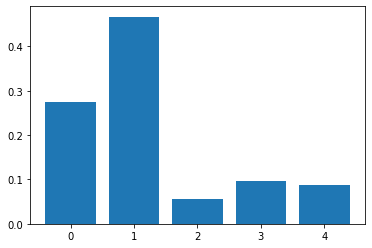

In [19]:
plt.bar(np.arange(infinity),trace['w'].mean(axis=0));

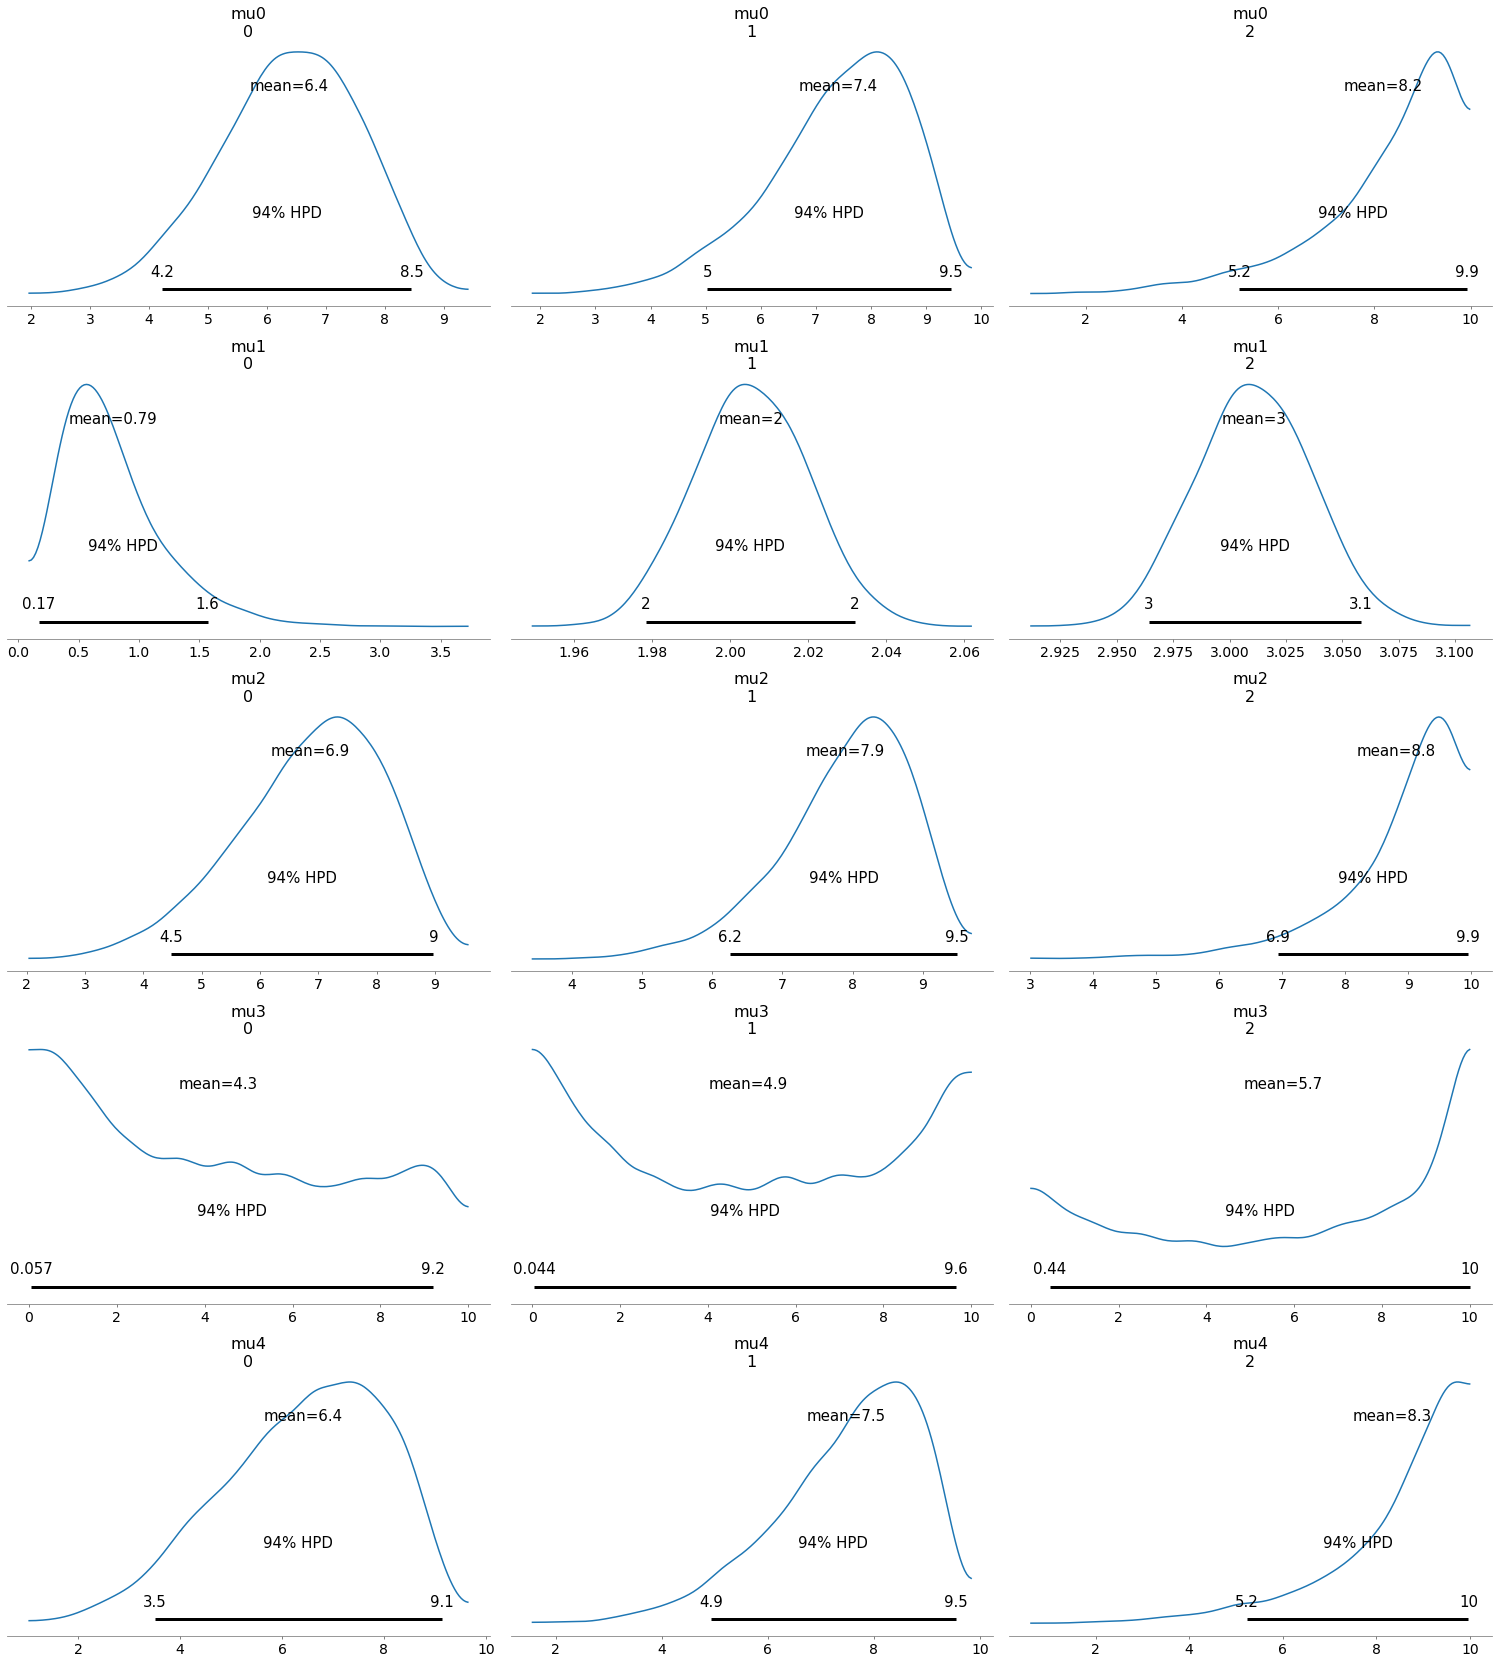

In [20]:
pm.plot_posterior(data=trace,var_names=['mu0','mu1','mu2','mu3','mu4'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu1'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu2'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu3'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu4'],backend="matplotlib");

In [ ]:
with model:
    trace = pm.sample(draws=5000,cores=8,tune=500)    

In [47]:
with model:
    trace = pm.find_MAP()

logp = -1.8318e+05, ||grad|| = 0.00077786: 100%|██████████| 13/13 [00:00<00:00, 3046.48it/s]  


In [ ]:
#print(pm.summary(trace))
#pm.traceplot(trace,varnames=['w'])
#t_finish = now()
#name=str(t_finish)